Reanalyze Helewell data relative to symtpom onset, also infer infection time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import datetime as dt
import pymc3 as pm
import theano
import theano.tensor as tt
import seaborn as sns

In [2]:
sympt = pd.read_csv('~/Documents/Github/pcr-profile/symptom_data.csv')
test = pd.read_csv('~/Documents/Github/pcr-profile/test_data.csv')
sympt
symponset = 4.8

In [3]:
ids = np.unique(sympt['num_id'])
sympt['day_no'] = np.zeros(len(sympt),dtype=np.int)
for i in np.arange(len(sympt)):
    dh = dt.datetime.strptime(sympt['date'][i],'%Y-%m-%d')
    td = dh - dt.datetime.strptime('2020-01-01','%Y-%m-%d')
    sympt.loc[i,'day_no'] = td.days

test['day_no'] = np.zeros(len(test),dtype=np.int)
for i in np.arange(len(test)):
    dh = dt.datetime.strptime(test['date'][i],'%Y-%m-%d')
    td = dh - dt.datetime.strptime('2020-01-01','%Y-%m-%d')
    test.loc[i,'day_no'] = td.days
    
first_day = np.min(test['day_no'].to_numpy())
last_day = np.max(test['day_no'].to_numpy())

In [4]:
symptids = np.array([],dtype=np.int)
for i in ids:
    if np.any(sympt['symptom'][sympt['num_id'] == i]):
        symptids = np.append(symptids,i)

sympt_lb = np.zeros(len(symptids),dtype=np.int)
sympt_ub = np.zeros(len(symptids),dtype=np.int)
test_first_pos = np.zeros(len(symptids),dtype=np.int)

test_days = np.zeros(len(symptids),dtype=np.object)
test_results = np.zeros(len(symptids),dtype=np.object)
total_tests = 0
for i in symptids:
    s = sympt['symptom'][sympt['num_id'] == i].to_numpy()
    d = sympt['day_no'][sympt['num_id'] == i].to_numpy()
    n = np.arange(len(s))
    nh = n[s][0]
    sympt_lb[i-1] = d[nh-1]
    sympt_ub[i-1] = d[nh]
    
    dtest = test['day_no'][test['num_id'] == i].to_numpy()
    t = test['pcr_result'][test['num_id'] == i].to_numpy()
    n = np.arange(len(t))
    if np.any(t > 0):
        nh = n[t][0]
        test_first_pos[i-1] = d[nh]
    else:
        test_first_pos[i-1] = last_day+1
    
    #could put extra tests in at start day
    test_days[i-1] = np.append(np.array([first_day-1]),dtest)
    test_results[i-1] = np.append(np.array([False]),t)
    
    #test_days[i-1] = dtest
    #test_results[i-1] = t
    
    total_tests += len(test_days[i-1])

All symptomatic

For each individual, define test times



In [5]:
X = np.zeros(total_tests)
Y = np.zeros(total_tests,dtype=np.bool)
Z = np.zeros(total_tests)
jcount = 0
for i in np.arange(len(symptids)):
    X[jcount:(jcount + len(test_days[i]))] = test_days[i]
    Y[jcount:(jcount + len(test_days[i]))] = test_results[i]
    Z[jcount:(jcount + len(test_days[i]))] = 0.5 * (sympt_lb[i] + sympt_ub[i])
    jcount += len(test_days[i])


In [6]:
test_model = pm.Model()
Nsamples = 2000
with test_model:    
    itimes = tt.zeros(len(symptids))
    sonset = tt.zeros(len(symptids))
    for i in np.arange(len(symptids)):
        naive_inftime = 0.5*(sympt_lb[i] + sympt_ub[i]) - 4.8
        ulim = np.min([sympt_ub[i],test_first_pos[i]])
        BoundedNormal = pm.Bound(pm.Normal, upper = ulim)
        itimes = tt.set_subtensor(itimes[i],BoundedNormal('inftime%d'%i, mu = naive_inftime, sigma = 5.0))
        llim =  pm.math.switch(sympt_lb[i] - itimes[i] > 0, sympt_lb[i] - itimes[i], 0)
        BoundedGamma = pm.Bound(pm.Gamma, lower = llim)
        sonset = tt.set_subtensor(sonset[i],pm.Uniform('sonset%d'%i, lower = llim, upper = sympt_ub[i] - itimes[i]))
    # Priors for unknown model parameters
    C = pm.Normal('C', mu = 0, sigma = 3.0)
    beta1 = pm.Normal('beta1', mu = 0, sigma = 1.0)
    beta2 = pm.Normal('beta2', mu = 0, sigma = 1.0) 
    beta3 = pm.Normal('beta3', mu = 0, sigma = 1.0)
    
    st = tt.zeros(total_tests)
    xobs = tt.zeros(total_tests)
    jcount = 0
    for i in np.arange(len(symptids)):
        if len(test_days[i]) > 0:
            xobs = tt.set_subtensor(xobs[jcount],itimes[i])  #false test here
            st = tt.set_subtensor(st[jcount:(jcount + len(test_days[i]))], itimes[i] + sonset[i])
        if len(test_days[i]) > 1:              
            xobs = tt.set_subtensor(xobs[(jcount+1):(jcount+len(test_days[i]))],\
                                   X[(jcount+1):(jcount+len(test_days[i]))])          
        jcount += len(test_days[i])
                      
    rate = pm.math.switch(xobs - st - C > 0, beta3, beta2)
    
    
    muh = 1 / (1 + pm.math.exp(beta1 + rate * (xobs - st - C)))
    Y_obs = pm.Bernoulli("Y_obs", p = muh, observed=Y)
    S_obs = pm.Gamma("S_obs", mu = symponset, sigma = 2.8, observed = sonset)
    
    param_samples = pm.sample(Nsamples, init='adapt_diag', tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, C, sonset26, inftime26, sonset25, inftime25, sonset24, inftime24, sonset23, inftime23, sonset22, inftime22, sonset21, inftime21, sonset20, inftime20, sonset19, inftime19, sonset18, inftime18, sonset17, inftime17, sonset16, inftime16, sonset15, inftime15, sonset14, inftime14, sonset13, inftime13, sonset12, inftime12, sonset11, inftime11, sonset10, inftime10, sonset9, inftime9, sonset8, inftime8, sonset7, inftime7, sonset6, inftime6, sonset5, inftime5, sonset4, inftime4, sonset3, inftime3, sonset2, inftime2, sonset1, inftime1, sonset0, inftime0]
Sampling 4 chains, 1 divergences: 100%|██████████| 12000/12000 [01:34<00:00, 127.65draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


(0, 1)

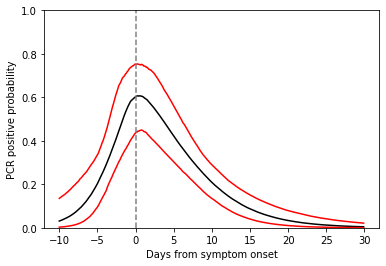

In [13]:
ndrange = np.arange(-10,30,0.1)
traces = np.zeros((len(ndrange), Nsamples))
for i in np.arange(Nsamples):
    Xh = ndrange - param_samples['C'][i]
    traces[:,i] =  1 / (1 + np.exp(param_samples['beta1'][i] + param_samples['beta3'][i] * Xh * (Xh>0) + \
                                   param_samples['beta2'][i] * Xh * (Xh<0)))
    
plt.plot(ndrange, np.median(traces,1),c='k')
plt.plot(ndrange, np.quantile(traces,0.975,1),c='r')
plt.plot(ndrange, np.quantile(traces,0.025,1),c='r')
plt.plot([0,0],[0,1],'--',c=[0.5,0.5,0.5])
plt.xlabel('Days from symptom onset')
plt.ylabel('PCR positive probability')
plt.ylim(0,1)

(array([8.000e+00, 5.100e+01, 2.430e+02, 5.680e+02, 1.056e+03, 1.405e+03,
        1.493e+03, 1.165e+03, 8.510e+02, 5.440e+02, 3.110e+02, 1.520e+02,
        7.700e+01, 3.600e+01, 2.100e+01, 1.200e+01, 3.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.08783333, 0.10588799, 0.12394265, 0.14199732, 0.16005198,
        0.17810664, 0.1961613 , 0.21421597, 0.23227063, 0.25032529,
        0.26837995, 0.28643462, 0.30448928, 0.32254394, 0.3405986 ,
        0.35865327, 0.37670793, 0.39476259, 0.41281725, 0.43087191,
        0.44892658]),
 <a list of 20 Patch objects>)

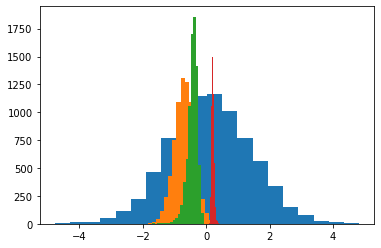

In [8]:
plt.hist(param_samples['C'],bins=20)
plt.hist(param_samples['beta1'],bins=20)
plt.hist(param_samples['beta2'],bins=20)
plt.hist(param_samples['beta3'],bins=20)

(85, 115)

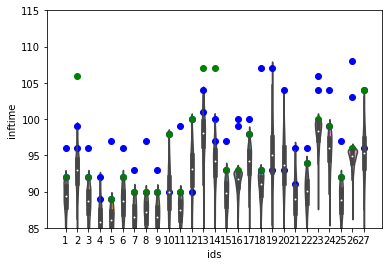

In [14]:
ids = np.zeros(Nsamples*len(symptids),dtype=np.int)
inftime = np.zeros(Nsamples*len(symptids))
sonset = np.zeros(Nsamples*len(symptids))
for n in np.arange(Nsamples):
    for j in np.arange(len(symptids)):
        ids[n*len(symptids) + j] = symptids[j]
        inftime[n*len(symptids) + j] = param_samples['inftime%d'%j][n]
        sonset[n*len(symptids) + j] = param_samples['sonset%d'%j][n]
        
dicth = {'ids':ids, 'inftime':inftime, 'sonset':sonset}
df = pd.DataFrame(dicth)

sns.violinplot(x='ids',y='inftime',data=df)
plt.scatter(symptids-1, sympt_lb, c='b')
plt.scatter(symptids-1, sympt_ub, c='r')
plt.scatter(symptids-1, test_first_pos, c='g')
plt.ylim(first_day,115)

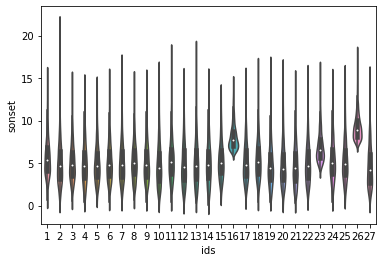

In [15]:
sns.violinplot(x='ids',y='sonset',data=df)

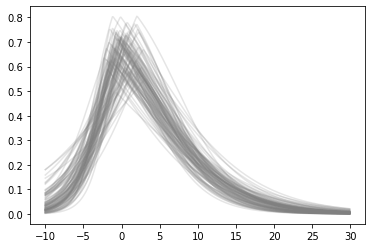

In [27]:
#plot some samples
plt.plot(ndrange,traces[:,np.random.choice(np.arange(1000),100,replace=False)],c=[0.5,0.5,0.5,0.2])